In [1]:
import pandas as pd 
import numpy as np 
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
def trim_categories(df, cols_list):
    for col in cols_list:
        df[col].cat.rename_categories(df[col].cat.categories.str.strip(), inplace=True)

### Import data, setting dtype to save memory

In [3]:
levels_keep_cols = ['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']
levels_col_types = {'TankId': 'category',
             'ExactFuelEventId': 'uint64',
             'TankLevelPercent': 'float32',
             'TankLevelGallons': 'float32'}
#Rows with TankId == '2' are dropped on read-in, after being manually identified
levels_fueltank_df = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv', 
                                 skiprows=[48671, 1824800, 4579415, 5656381],
                                 usecols = levels_keep_cols, 
                                 dtype=levels_col_types ).drop(
    ['TankId'], axis=1)

#levels_fueltank_df = levels_fueltank_df.set_index('ExactFuelEventId').drop(['TankId'], axis=1)

#### Fuel Optimization data; only need tank capacity

In [4]:
optimization_fuel_df = pd.read_csv('data/BGEIDSC.EF2EFFP.csv',
                                   dtype={'TANKCAP': 'uint16', 'TRUCK' : 'uint32'},
                                  usecols = ['TRUCK', 'TANKCAP'])
optimization_fuel_df.columns = [s.lower() for s in optimization_fuel_df.columns]

In [5]:
#trim_categories(optimization_fuel_df, ['truck'])
#optimization_fuel_df.set_index('truck', inplace=True)

In [6]:
units_df = pd.read_csv('data/IBGEFILE.UNITS.csv', 
                       dtype = {'UNMAKE': 'category'})
#Can drop non-int units
units_df.columns = ['unit_number', 'model_year', 'make'] 

# Trim white space from category strings 

# Remove invalid entries
units_df.unit_number = pd.to_numeric(units_df.unit_number, errors = 'coerce')
units_df = units_df[units_df.unit_number != 1].dropna()
#units_df = units_df[units_df.unit_number.isin(['ZEBE', 'CCTRK', 'BGXL', '1']) == False]
#set index

trim_categories(units_df, ['make'])
# Fix typos
units_df.make[units_df.make.isin(['KENOWRTH', 'KEWORTH'])] = 'KENWORTH'


In [7]:
units_df.make.cat.categories

Index(['', 'FREIGHTLINER', 'KENOWRTH', 'KENWORTH', 'KEWORTH', 'MACK',
       'PETERBILT', 'SYSTEM TEST', 'VOLVO'],
      dtype='object')

In [8]:
units_df.make.value_counts()

KENWORTH        526
VOLVO           139
FREIGHTLINER     15
PETERBILT        14
MACK             10
SYSTEM TEST       0
KEWORTH           0
KENOWRTH          0
                  0
Name: make, dtype: int64

In [9]:
transaction_df_cols = ['tr_id', 'tr_date', 'tr_time', 'tr_station_id', 'tr_station_name',
                         'tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 
                         'tr_item_cd1', 'tr_item_qty1', 'tr_item_cd2', 'tr_item_qty2',
                          'tr_item_cd3', 'tr_item_qty3', 'tr_item_cd4', 'tr_item_qty4',
                          'tr_item_cd5', 'tr_item_qty5', 'tr_item_cd6', 'tr_item_qty6']
tr_dtypes= {'tr_id' : 'uint32',  
            'tr_date' : 'uint32', 
            'tr_time' : 'uint32', 
            'tr_station_name' : 'object', 
            'tr_station_cty' : 'object', 
            'tr_station_st' : 'object', 
            'tr_drvr_code' : 'category', 
            'tr_unit_id' : 'category', 
            'tr_item_cd1' : 'category', 
            'tr_item_qty1' : 'float32', 
            'tr_item_cd2' : 'category', 
            'tr_item_qty2' : 'float32', 
            'tr_item_cd3' : 'category', 
            'tr_item_qty3' : 'float32', 
            'tr_item_cd4' : 'category', 
            'tr_item_qty4' : 'float32', 
            'tr_item_cd5' : 'category', 
            'tr_item_qty5' : 'float32', 
            'tr_item_cd6' : 'category', 
            'tr_item_qty6' : 'float32'}
act_fuel_transactions = ['ULSD', 'FUEL', 'CDSL', 'DSL1', 'BDSL']
transaction_df = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv', names = transaction_df_cols, dtype = tr_dtypes, header=0 )

# Trim white space from category strings 
trim_categories(transaction_df, ['tr_drvr_code','tr_unit_id','tr_item_cd1', 'tr_item_cd2', 'tr_item_cd3', 'tr_item_cd4', 'tr_item_cd5', 'tr_item_cd6' ])

#### Create datetime column in transactions_df

In [10]:
#confirm no junk data in this col (returns false if no NaNs)
None in transaction_df.tr_time

# 20170112 3

#Combine tr_date and tr_time into a single date time column
    #1. zero pad tr_time on left for interpretation as military time
        #cast tr_time as string
transaction_df.tr_time = transaction_df.tr_time.astype(str)

# 20170112 '3' Time column is now a string
#ensure none of my strings are over 4 digits in length
for s in transaction_df.tr_time:
    assert len(s) < 5

#check for blanks
'' in transaction_df.tr_time

#add zeros to the left until each cell is len 4
zero_padded_time = []
for s in transaction_df.tr_time:
    while len(s) < 4:
        s = '0' + s
    zero_padded_time.append(s)
# 20170112 '0003' zero padded minutes
#spot check
for s in zero_padded_time:
    assert len(s) == 4

transaction_df.tr_time = zero_padded_time

#append tr_date (as string) and tr_time together, and then convert them to dateime
#transaction_df.tr_datetime 
tst = [datetime.strptime(str(d) + 
                         t, '%Y%m%d%H%M') 
       for d, t in zip(transaction_df.tr_date,
                       transaction_df.tr_time)]
#love list comprehensions

transaction_df['tr_datetime'] = tst#assign

#drop superfluous columns
transaction_df.drop(['tr_date','tr_time'], axis = 'columns', inplace=True)
transaction_df.head()

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
0,42574765,520277,FLYING J VANDALIA 97,VANDALIA,OH,ULAL,1564,SCLE,1.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 00:20:00
1,42575331,516202,PILOT NEW BRAUNFELS 330,NEW BRAUNFELS,TX,MANRI,1584,ULSD,137.399994,DEFD,7.71,CADV,1.0,,0.0,,0.0,,0.0,2017-01-01 00:48:00
2,42578678,516277,PILOT 421,DALTON,GA,RUSR,1713,ULSD,137.929993,DEFD,4.12,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:34:00
3,42578722,231100,FJ-BRUNSWICK 627,BRUNSWICK,GA,FOSJA,1711,ULSD,45.000000,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 01:37:00
4,42579695,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HICWIL,1837,ULSD,107.360001,,0.00,,0.0,,0.0,,0.0,,0.0,2017-01-01 03:02:00


In [11]:
transaction_df.tr_item_cd2.value_counts()

        96333
DEFD    42468
CADV     8196
ADD       348
OIL       264
SCLE      236
UREA       15
WWFL        1
Name: tr_item_cd2, dtype: int64

In [12]:
# These rows are dropped
transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '']) == True]

,tr_id,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id,tr_item_cd1,tr_item_qty1,tr_item_cd2,tr_item_qty2,tr_item_cd3,tr_item_qty3,tr_item_cd4,tr_item_qty4,tr_item_cd5,tr_item_qty5,tr_item_cd6,tr_item_qty6,tr_datetime
1174,42977478,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 07:40:00
1383,43037746,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,130.570007,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-05 14:57:00
6812,44866479,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,60.790001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 06:08:00
6955,44908231,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,HILB,,ULSD,30.440001,,0.0,,0.0,,0.0,,0.0,,0.0,2017-01-21 14:33:00
13493,47176337,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,96.269997,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-09 09:11:00
15203,47747773,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,62.840000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-14 10:46:00
16503,48174487,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,82.480003,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 11:53:00
16583,48198811,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SPED,OFFICE,ULSD,50.000000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-17 15:01:00
17310,48478526,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,1974,,ULSD,10.060000,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-20 12:12:00
18077,48727766,523050,BIG G EXPRESS TERMINAL,GLADEVILLE,TN,SMIFR,,ULSD,88.010002,,0.0,,0.0,,0.0,,0.0,,0.0,2017-02-22 09:42:00


In [13]:
# Drops Office and blank Unit IDs
#transaction_df = transaction_df[transaction_df.tr_unit_id.isin(['OFFICE', '      ']) == False]

In [14]:
events_keep_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 
                    'DriverID', 'Latitude', 'Longitude', 'LocationTimeStamp', 
                    'Speed', 'Odometer', 'IgnitionStatus', 'EFReportReason']
events_col_types = {'DriverID': 'category',
             'EFReportReason': 'category',
             'EquipmentID': 'uint32',
             'Id': 'uint64',
             'IgnitionStatus': 'category',
             'Latitude': 'float64',
             'Longitude': 'float64',
             'Odometer': 'float64',
             'Speed': 'uint16'}

events_levels_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True).merge(
    levels_fueltank_df, copy=False, how='inner', left_on='Id', right_on='ExactFuelEventId').merge(
    optimization_fuel_df, copy=False, how='left', left_on='EquipmentID', right_on = 'truck')
trim_categories(events_levels_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])

In [15]:
'''events_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', 
                             usecols=events_keep_cols, 
                            dtype=events_col_types, 
                             index_col = 'EventTimeStamp',
                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], 
                            infer_datetime_format=True)
trim_categories(events_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])
'''

"events_df = pd.read_csv('data/Extranet2.ExactFuelEvents.csv', \n                             usecols=events_keep_cols, \n                            dtype=events_col_types, \n                             index_col = 'EventTimeStamp',\n                             parse_dates=['EventTimeStamp', 'LocationTimeStamp'], \n                            infer_datetime_format=True)\ntrim_categories(events_df, ['DriverID','EFReportReason', 'IgnitionStatus' ])\n"

In [16]:
# Save 220 MB memory and 
levels_fueltank_df.index = levels_fueltank_df.index.astype('uint64')
gc.collect()

2828

In [17]:
ls data/

BGEIDSC.EF2EFFP.csv                  Extranet2.QCPerformanceExtracts.csv*
BGETCHDATA.PTCHTRANH.csv*            IBGEFILE.UNITS.csv*
Extranet2.ExactFuelEvents.csv*       t.4.01.0.jpg.png
Extranet2.ExactFuelTankLevels.csv*


In [18]:
performance_df = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv',
                            parse_dates=['EventTimeStamp','LocationTimeStamp', 'DataStartTimeStamp','DataEndTimeStamp' ], 
                            infer_datetime_format=True)
# Remove invalid Truck IDs
performance_df = performance_df[performance_df.EquipmentID < 9999]

In [19]:
performance_df[performance_df.RegisteredDriver == 0].DriverID.value_counts()

000000000    65
STEMI        58
MARC         55
LOVH         55
FISG         54
BUFB         54
PEAA         54
NEWR         54
STEGA        54
JONCH        53
TUSR         53
COLJAM       53
WALCA        52
THODAV       52
HOWLE        52
BAYJ         52
WILT01       52
GREG         52
ANTR         52
SHAMAR       52
BROBO        52
VANCH        52
WESD         52
MARMIS       52
FIEMI        52
SCHD         52
MEAJ         51
ARCM         51
HARTI        51
POPP         51
             ..
TEDS          1
ARNMA         1
BANC          1
WHIGRA        1
TALM          1
LAWBR         1
CAIB          1
SMIFRA        1
WILED         1
WILSTE        1
SIZD          1
BINJA         1
CARJON        1
BATK          1
SIMJIM        1
WAKT          1
NEWC          1
PITG          1
CAREL         1
NORLA         1
MART01        1
REYJ          1
NELS          1
BONK          1
PORJ          1
BEVR          1
BURD          1
LOPJO         1
GOOJO         1
POLA          1
Name: DriverID, Length: 

In [20]:
perf_cols = ['Id', 'EventTimeStamp', 'EquipmentID', 'DriverID', 'IgnitionStatus', 'TripStatus',
       'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'DriveTime',
       'EngineTime', 'MoveTime', 'IntertripIdleTime', 'ShortIdleTime',
       'OverSpeedTime', 'TotalFuelUsed', 'IdleFuelUsed',
        'CruiseControlTime', 'TopGearTime',
       'GearDataSource', 'SpeedUnits', 'LocationTimeStamp', 'Latitude', 'Longitude', 
            'FaultFlag', 'RegisteredDriver',]
performance_df.columns

Index(['Id', 'ESS_Id', 'EventTimeStamp', 'EquipmentID', 'MCTNumber',
       'EquipmentType', 'DriverID', 'Driver2ID', 'Latitude', 'Longitude',
       'LocationTimeStamp', 'IgnitionStatus', 'TripStatus',
       'DataStartTimeStamp', 'DataEndTimeStamp', 'Distance', 'DriveTime',
       'EngineTime', 'MoveTime', 'IntertripIdleTime', 'ShortIdleTime',
       'OverSpeedTime', 'ExcessSpeedTime', 'TotalFuelUsed', 'IdleFuelUsed',
       'FaultFlag', 'RegisteredDriver', 'CruiseControlTime', 'TopGearTime',
       'GearDataSource', 'SpeedUnits', 'SpeedMatrix'],
      dtype='object')

In [21]:
df_names_list = ['events_levels_df', 'levels_fueltank_df', 'optimization_fuel_df', 'units_df', 'transaction_df', 'performance_df']
df_list = [events_levels_df, levels_fueltank_df, optimization_fuel_df, units_df, transaction_df, performance_df]
df_dict = dict(zip(df_names_list, df_list))

for k, v in df_dict.items():
    print(k + ' shape: ' + str(v.shape))

events_levels_df shape: (7908406, 16)
levels_fueltank_df shape: (7908824, 3)
optimization_fuel_df shape: (836, 2)
units_df shape: (704, 3)
transaction_df shape: (147861, 20)
performance_df shape: (32253, 32)


In [22]:
events_levels_df.head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,2017-01-01 00:00:30,0,39895.5,2,1,50.700001,101.400002,12649083,1992,200
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,2017-01-01 00:01:27,0,360378.8,1,2,78.000000,156.000000,12649084,1712,200
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,2017-01-01 00:04:17,67,377577.4,1,2,31.700001,63.400002,12649092,1713,200
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,2017-01-01 00:04:10,0,513931.8,1,2,43.200001,108.000000,12649102,1585,250
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250


#### Events grouped by Driver and Truck

In [23]:
dt_grouped = events_levels_df.groupby(['DriverID', 'EquipmentID'])

#### Sizes of groups as a dataframe

In [24]:
dt_sizes = dt_grouped.size().to_frame('events').sort_values('events', ascending=False)

In [25]:
dt_sizes.shape

(2151, 1)

In [26]:
dt_sizes[dt_sizes.events < 20].shape[0]

340

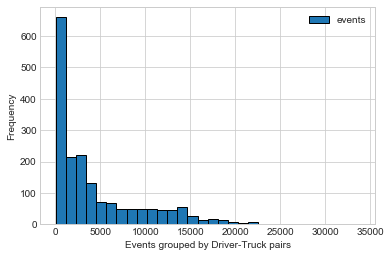

In [27]:
sns.set_style('whitegrid')
plt.rcParams["patch.force_edgecolor"] = True
dt_sizes[dt_sizes.events > 20].plot(kind='hist', bins=30)
plt.xlabel('Events grouped by Driver-Truck pairs')
plt.show()

In [28]:
dt_sizes.head(50).sort_index()

,,events
DriverID,EquipmentID,
ADAR,1950,18387
ANTR,1721,20956
ARCM,307,18415
BALD,1991,19249
BINA,1961,17271
BROD03,1941,22014
BUFB,1799,18922
BULR,1639,17809
BYRCHR,1734,18425


### Sample data for specific drivers

In [29]:
sample_drivers = ['EDWTI']
sample_trucks = ['2014']
events_col_list = ['EventTimeStamp', 'Odometer', 'TankLevelPercent', 'IgnitionStatus', 'EFReportReason',
                   'Speed',  'TankLevelGallons', 'Latitude', 'Longitude', 'LocationTimeStamp',
                  'tankcap', 'EquipmentID', 'DriverID']
sample_bool_series = np.logical_and(events_levels_df.DriverID.isin(sample_drivers), 
                                   events_levels_df.EquipmentID.isin(sample_trucks))
drivers_events = events_levels_df[sample_bool_series].loc[:, events_col_list].set_index('EventTimeStamp')

In [30]:
drivers_events.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20294 entries, 2017-01-07 17:28:16.870000 to 2018-03-23 08:19:22.510000
Data columns (total 12 columns):
Odometer             20294 non-null float64
TankLevelPercent     20294 non-null float32
IgnitionStatus       20294 non-null category
EFReportReason       20294 non-null category
Speed                20294 non-null uint16
TankLevelGallons     20294 non-null float32
Latitude             20294 non-null float64
Longitude            20294 non-null float64
LocationTimeStamp    20294 non-null datetime64[ns]
tankcap              20294 non-null uint16
EquipmentID          20294 non-null uint32
DriverID             20294 non-null category
dtypes: category(3), datetime64[ns](1), float32(2), float64(3), uint16(2), uint32(1)
memory usage: 1.2 MB


In [31]:
'''event_col_list = ['Odometer',  'IgnitionStatus', 'EFReportReason',
                   'Speed',  'Latitude', 'Longitude', 'LocationTimeStamp',
                  'EquipmentID', 'DriverID']
driver_event_filter = np.logical_and(events_df.DriverID.isin(sample_drivers), 
                                   events_df.EquipmentID.isin(sample_trucks))
drivers_events_full = events_df[driver_event_filter].loc[:, event_col_list]'''

"event_col_list = ['Odometer',  'IgnitionStatus', 'EFReportReason',\n                   'Speed',  'Latitude', 'Longitude', 'LocationTimeStamp',\n                  'EquipmentID', 'DriverID']\ndriver_event_filter = np.logical_and(events_df.DriverID.isin(sample_drivers), \n                                   events_df.EquipmentID.isin(sample_trucks))\ndrivers_events_full = events_df[driver_event_filter].loc[:, event_col_list]"

In [32]:
drivers_events.loc['2017-01-12 05:56': '2017-01-12 12:15']

,Odometer,TankLevelPercent,IgnitionStatus,EFReportReason,Speed,TankLevelGallons,Latitude,Longitude,LocationTimeStamp,tankcap,EquipmentID,DriverID
EventTimeStamp,,,,,,,,,,,,
2017-01-12 05:56:31.780,1597.5,27.900000,2,0,0,55.799999,40.23532,-77.12209,2017-01-12 05:55:57,200,2014,EDWTI
2017-01-12 06:12:31.797,1597.6,70.199997,2,1,0,140.399994,40.23534,-77.12239,2017-01-12 06:12:31,200,2014,EDWTI
2017-01-12 06:16:01.797,1597.7,100.000000,1,0,10,200.000000,40.23444,-77.12103,2017-01-12 06:16:01,200,2014,EDWTI
2017-01-12 06:31:01.843,1608.3,100.000000,1,2,64,200.000000,40.19640,-77.00968,2017-01-12 06:31:01,200,2014,EDWTI
2017-01-12 07:31:02.280,1669.4,100.000000,1,2,61,200.000000,40.17710,-75.92836,2017-01-12 07:31:01,200,2014,EDWTI
2017-01-12 08:30:59.413,1730.5,95.800003,1,2,54,191.600006,40.12595,-74.87093,2017-01-12 08:31:02,200,2014,EDWTI
2017-01-12 09:04:39.447,1762.3,93.199997,1,2,7,186.399994,40.34993,-74.48066,2017-01-12 09:04:42,200,2014,EDWTI
2017-01-12 09:14:49.460,1764.2,96.199997,2,1,0,192.399994,40.35500,-74.45721,2017-01-12 09:14:52,200,2014,EDWTI
2017-01-12 09:19:49.507,1764.6,99.000000,1,0,7,198.000000,40.35387,-74.45072,2017-01-12 09:19:52,200,2014,EDWTI


In [33]:
'''events_df.info(memory_usage='deep')'''

"events_df.info(memory_usage='deep')"

In [34]:
'''#drivers_events_full.info()
len(drivers_events_full.loc['2017-01-12'])
#drivers_events_full.head()'''

"#drivers_events_full.info()\nlen(drivers_events_full.loc['2017-01-12'])\n#drivers_events_full.head()"

In [35]:
sample_drivers = ['EDWTI']
sample_trucks = ['2014']
trans_col_list = ['tr_datetime','tr_item_cd1', 'tr_item_qty1', 'tr_station_id', 
                  'tr_station_name','tr_station_cty', 'tr_station_st', 'tr_drvr_code', 'tr_unit_id']
    

sample_tran_bool_series = np.logical_and(transaction_df.tr_drvr_code.isin(sample_drivers), 
                                   transaction_df.tr_unit_id.isin(sample_trucks))
drivers_trans = transaction_df[sample_tran_bool_series].loc[:, trans_col_list].sort_values(['tr_datetime'])

In [36]:
transaction_df.columns

Index(['tr_id', 'tr_station_id', 'tr_station_name', 'tr_station_cty',
       'tr_station_st', 'tr_drvr_code', 'tr_unit_id', 'tr_item_cd1',
       'tr_item_qty1', 'tr_item_cd2', 'tr_item_qty2', 'tr_item_cd3',
       'tr_item_qty3', 'tr_item_cd4', 'tr_item_qty4', 'tr_item_cd5',
       'tr_item_qty5', 'tr_item_cd6', 'tr_item_qty6', 'tr_datetime'],
      dtype='object')

In [37]:
drivers_trans[:4]

,tr_datetime,tr_item_cd1,tr_item_qty1,tr_station_id,tr_station_name,tr_station_cty,tr_station_st,tr_drvr_code,tr_unit_id
3625,2017-01-12 06:10:00,ULSD,138.0,231060,FJ-CARLISLE 708,CARLISLE,PA,EDWTI,2014
4034,2017-01-13 06:00:00,SCLE,1.0,516089,PILOT 179,HAGERSTOWN,MD,EDWTI,2014
4154,2017-01-13 10:55:00,ULSD,102.0,231846,FJ-MAX MEADOWS 750,FORT CHISWELL,VA,EDWTI,2014
4447,2017-01-14 09:19:00,SCLE,1.0,516127,PILOT MIDDLESBORO 240,MIDDLESBORO,KY,EDWTI,2014


## Cleaning up odometer data in evets_levels_df

In [38]:
events_levels_df.head()

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,2017-01-01 00:00:30,0,39895.5,2,1,50.700001,101.400002,12649083,1992,200
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,2017-01-01 00:01:27,0,360378.8,1,2,78.000000,156.000000,12649084,1712,200
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,2017-01-01 00:04:17,67,377577.4,1,2,31.700001,63.400002,12649092,1713,200
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,2017-01-01 00:04:10,0,513931.8,1,2,43.200001,108.000000,12649102,1585,250
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250


In [39]:
#Are there bad odometer readings?
events_levels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7908406 entries, 0 to 7908405
Data columns (total 16 columns):
Id                   uint64
EventTimeStamp       datetime64[ns]
EquipmentID          uint32
DriverID             category
Latitude             float64
Longitude            float64
LocationTimeStamp    datetime64[ns]
Speed                uint16
Odometer             float64
IgnitionStatus       category
EFReportReason       category
TankLevelPercent     float32
TankLevelGallons     float32
ExactFuelEventId     uint64
truck                uint32
tankcap              uint16
dtypes: category(3), datetime64[ns](2), float32(2), float64(3), uint16(2), uint32(2), uint64(2)
memory usage: 663.7 MB


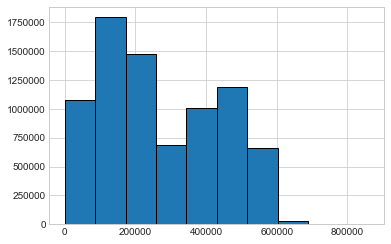

In [40]:
#well at least they're all floats. I guess I could try a histogram
_ = plt.hist(events_levels_df.Odometer)
plt.show()

In [41]:
#Ok so, some readings are quite high. 
#And while it is rare that a truck would have 600,000 + miles on it. 
#at least there is nothing absurd like a million miles.

#I guess I could group by truck, and then check a timeseries of odometer
#for each truck. the mileage should increase gradually for all trucks.

#So how many trucks are there?
#len(set(events_levels_df.truck)) #there are 629 trucks.

629

In [42]:
#len(set(events_levels_df.EquipmentID)) #confirming its a 1 to 1 match with truck

629

In [45]:
#set(events_levels_df.EquipmentID) == set(events_levels_df.truck)
#confirming the sets are the same This took 2 minutes but it was True

True

In [49]:
#so drop the unecessary column of EquipmentID
events_levels_df.drop('EquipmentID', axis = 1, inplace = True)

In [43]:
set(events_levels_df.truck) #quick visual inspection

{301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 1508,
 1513,
 1516,
 1519,
 1520,
 1521,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1534,
 1535,
 1537,
 1539,
 1543,
 1547,
 1548,
 1549,
 1550,
 1551,
 1552,
 1554,
 1555,
 1556,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 1564,
 1565,
 1566,
 1567,
 1568,
 1569,
 1570,
 1571,
 1572,
 1573,
 1574,
 1575,
 1576,
 1577,
 1578,
 1579,
 1580,
 1581,
 1582,
 1583,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592,
 1593,
 1594,
 1595,
 1596,
 1597,
 1598,
 1599,
 1600,
 1601,
 1602,
 1603,
 1604,
 1607,
 1608,
 1609,
 1610,
 1611,
 1612,
 1613,
 1614,
 1615,
 1616,
 1617,
 1618,
 1619,
 1620,
 1621,
 1622,
 1623,
 1624,
 1625,
 1626,
 1627,
 1628,
 1629,
 1630,
 1631,
 1632,
 1633,
 1634,
 1635,
 1636,
 1638,
 1639,
 1640,
 1641,
 1642,
 1643,
 1644,
 1645,
 1647,
 1648,
 1649,
 1650,
 1651,
 1652,
 1653,
 1654,
 1655,
 1656,
 1657,
 1658,
 1659,
 1660,
 1661,
 1662,
 1663,
 1664,
 1665,
 1666,
 1

In [54]:
#so.... group by truck, sort by time and plot odometer time series?
    #I don't need 629 plots...
    #Can I handle, 629 lines on a single plot? sounds computationally expensive

#Numerical approach: group by truck, sort chronologically
    #for each row in df:
        #if (truck i == truck i+1) and (Odometer i+1 - Odometer i > 500):
            #print('found weird jump between odometer i and odometer i+1 for truck t')

events_levels_df[0:100].sort_values(['truck', 'EventTimeStamp'])

,Id,EventTimeStamp,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,Odometer,IgnitionStatus,EFReportReason,TankLevelPercent,TankLevelGallons,ExactFuelEventId,truck,tankcap
4,12649103,2017-01-01 00:10:13.187,ULAL,39.90268,-84.19254,2017-01-01 00:10:11,3,498691.0,1,2,50.299999,125.750000,12649103,1564,250
44,12649143,2017-01-01 00:12:23.187,ULAL,39.90267,-84.19318,2017-01-01 00:12:21,9,498691.1,1,1,50.599998,126.500000,12649143,1564,250
45,12649144,2017-01-01 00:14:13.187,ULAL,39.90259,-84.19231,2017-01-01 00:14:11,0,498691.2,2,1,50.400002,126.000000,12649144,1564,250
46,12649145,2017-01-01 00:14:34.267,ULAL,39.90262,-84.19234,2017-01-01 00:14:32,0,498691.2,2,0,50.400002,126.000000,12649145,1564,250
47,12649146,2017-01-01 00:32:13.267,ULAL,39.90261,-84.19228,2017-01-01 00:32:11,0,498691.2,2,1,48.799999,122.000000,12649146,1564,250
48,12649147,2017-01-01 00:36:23.297,ULAL,39.90302,-84.19245,2017-01-01 00:36:21,9,498691.2,1,0,48.000000,120.000000,12649147,1564,250
49,12649148,2017-01-01 00:51:23.390,ULAL,39.75214,-84.18651,2017-01-01 00:51:21,57,498703.8,1,2,48.000000,120.000000,12649148,1564,250
10,12649109,2017-01-01 00:14:33.237,MANRI,29.53947,-98.37978,2017-01-01 00:14:34,56,500730.0,1,2,30.900000,77.250000,12649109,1584,250
20,12649119,2017-01-01 00:30:13.330,MANRI,29.67382,-98.15442,2017-01-01 00:30:14,10,500746.3,1,2,28.400000,71.000000,12649119,1584,250
29,12649128,2017-01-01 00:36:13.393,MANRI,29.67678,-98.15673,2017-01-01 00:36:14,0,500747.1,2,1,29.000000,72.500000,12649128,1584,250


In [65]:
events_levels_df[0:50].pivot(index = 'EventTimeStamp', 
                              columns = 'truck',
                             values = 'Odometer')

truck,1564,1584,1585,1612,1672,1693,1707,1711,1712,1713,1730,1787,1913,1922,1992
EventTimeStamp,,,,,,,,,,,,,,,
2017-01-01 00:00:32.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39895.5
2017-01-01 00:01:24.867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360378.8,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:04:10.260,NaN,NaN,513931.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:04:15.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377577.4,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:10:13.187,498691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:11:08.123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:11:48.803,NaN,NaN,NaN,NaN,NaN,340043.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:12:23.187,498691.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:12:26.077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224306.6,NaN,NaN,NaN


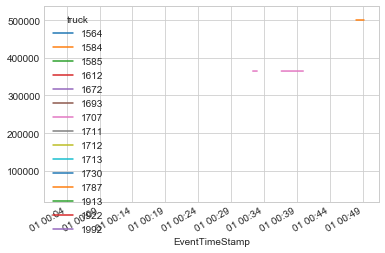

In [63]:
events_levels_df[0:50].pivot(index = 'EventTimeStamp', columns = 'truck', 
                      values = 'Odometer').plot()
plt.show()

In [66]:
events_levels_df[events_levels_df.truck == 1564].plot(x = 'EventTimeStamp', y = 'Odometer')

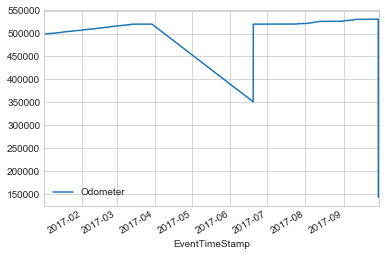

In [67]:
plt.show()

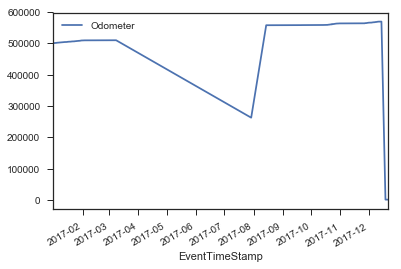

In [92]:
events_levels_df[events_levels_df.truck == 1584].plot(x = 'EventTimeStamp', y = 'Odometer')
plt.show()

In [ ]:
#try with sns
sns.set(style='darkgrid')

#f, ax = plt.subplots(figsize = (100,20))

#sns.factorplot(x = 'EventTimeStamp', y = 'Odometer', #kind = 'bar',
              hue = 'truck',
               #row = 'truck',
               data = events_levels_df)
plt.show()

sns.tsplot(time = 'EventTimeStamp', value = 'Odometer', 
           #unit = 'truck',
           condition = 'truck', data = events_levels_df[0:50])
plt.show()

### Approach 1: Intervals between transactions 


### Approach 2: Max Odometer between transaction timestamps
#### Outlier odometer readings: Use diff method for decreases in odometer 